# **TA #4 - Python version**

## Foundation of Econometrics - DSDM 2025-2026

**Lucia Sauer**

**Contact:** [lucia.sauer@bse.eu](mailto:lucia.sauer@bse.eu)

In this notebook we will review:

1. Hypothesis testing with several restrictions
2. Monte Carlo Simulations



In [30]:
import wooldridge as woo
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context = 'talk')

Let's start by running the following regression:

$$\texttt{colGPA}_i​=\beta_1​+\beta_2\texttt{​hsGPA}_i​+\beta_3​\texttt{job19}_i​
+\beta_4​\texttt{job20}_i​
+\beta_5​\texttt{skipped}_i​+\beta_6​\texttt{bgfriend}_i​+\beta_7​\texttt{alcohol}_i​ +\varepsilon_i​ $$

where:

- $\texttt{colGPA}$: college GPA
- $\texttt{hsGPA}$: high school GPA
- $\texttt{job19}$: worked in 2019 (1=yes, 0=no)
- $\texttt{job20}$: worked in 2020 (1=yes, 0=no)
- $\texttt{skipped}$: skipped classes (1=yes, 0=no)
- $\texttt{bgfriend}$: has a boyfriend/girlfriend (1=yes, 0=no)
- $\texttt{alcohol}$: alcohol consumption (1=yes, 0=no)

In [31]:
data = woo.data('gpa1')

model_full = sm.OLS.from_formula(
    "colGPA ~ hsGPA + job19 + job20 + skipped +  alcohol + bgfriend", data=data
).fit()
print(model_full.summary())


                            OLS Regression Results                            
Dep. Variable:                 colGPA   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     7.744
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           3.69e-07
Time:                        00:40:57   Log-Likelihood:                -39.270
No. Observations:                 141   AIC:                             92.54
Df Residuals:                     134   BIC:                             113.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4764      0.307      4.805      0.0

## **Global Hypothesis Testing**

---


In [32]:
# Modelo sin las dummies de año (restringido)
data['intercept'] = 1  # Añadir una columna de intercepto
model_restricted = sm.OLS.from_formula(
    "colGPA ~ intercept", data=data
).fit()

# Modelo con las dummies (no restringido)
model_unrestricted = sm.OLS.from_formula(
    "colGPA ~ hsGPA + job19 + job20 + skipped +  alcohol + bgfriend", data=data
).fit()

#Compute manually the F-statistic
RSSE = np.sum((data['colGPA'] - np.mean(data['colGPA']))**2)
SSE = model_unrestricted.ssr
F_manual = ((RSSE - SSE) / 6) / (SSE / (data.shape[0] - 7))
print(f"F-statistic (manual calculation): {F_manual:.4f}")
# Compare with the F-statistic from the unrestricted model
print(f"F-statistic (from model): {model_unrestricted.fvalue:.4f}")

print (f"p-value (from model): {model_unrestricted.f_pvalue:.4f}")

#calculate p-value manually
p_value_manual = 1 - stats.f.cdf(F_manual, 6, data.shape[0] - 7)
print(f"p-value (manual calculation): {p_value_manual:.4f}")


F-statistic (manual calculation): 7.7436
F-statistic (from model): 7.7436
p-value (from model): 0.0000
p-value (manual calculation): 0.0000


## **Multiple Hypothesis Testing**
---

Test whether <code>job19</code> and <code>job20</code> are jointly statiscally significant

In [39]:
# Modelo sin las dummies de año (restringido)
data['intercept'] = 1  # Añadir una columna de intercepto
model_restricted = sm.OLS.from_formula(
    "colGPA ~ hsGPA + skipped +  alcohol + bgfriend", data=data
).fit()

# Modelo con las dummies (no restringido)
model_unrestricted = sm.OLS.from_formula(
    "colGPA ~ hsGPA + job19 + job20 + skipped +  alcohol + bgfriend", data=data
).fit()

#Compute manually the F-statistic
RSSE = model_restricted.ssr
SSE = model_unrestricted.ssr
F_manual = ((RSSE - SSE) / 2) / (SSE / (data.shape[0] - 7))

print(f"F-statistic (manual calculation): {F_manual:.4f}")
#calculate p-value manually
p_value_manual = 1 - stats.f.cdf(F_manual, 2, data.shape[0] - 7)
print(f"p-value (manual calculation): {p_value_manual:.4f}")


F-statistic (manual calculation): 0.4909
p-value (manual calculation): 0.6132


## **Monte Carlo Simulation**

---

- Examine the *sampling distribution* of the estimator when:
  
    1. Increase the variance of the error term
    2. Increase the degree of collinearity
    3. Increase the sample size (consistency)

$$
y_i = 4 + 2x_{i2} + 2x_{i3} + \varepsilon_i 
$$

$$\varepsilon_i \,|\, X_i \sim \text{i.i.d. } N(0,32)$$

$$
x_{i2} \sim U[0,40], \quad
x_{i3} = x_{i2} + v_i, \; v_i \sim N(0, 16)
$$


In [19]:
def simulate_betas(n=100, sigma_eps=4, sigma_v=4, reps=1000, conditional=False):
    """
    Monte Carlo simulation of β₂ from y = 4 + 2x₂ + 2x₃ + ε.
    """
    betas = []
    
    # For conditional distribution: fix X once
    if conditional:
        x2_fixed = np.random.uniform(0, 40, n)
        v_fixed  = np.random.normal(0, sigma_v, n)
        x3_fixed = x2_fixed + v_fixed
    
    for _ in range(reps):
        if conditional:
            x2, x3 = x2_fixed, x3_fixed
        else:
            x2 = np.random.uniform(0, 40, n)
            v  = np.random.normal(0, sigma_v, n)
            x3 = x2 + v

        eps = np.random.normal(0, sigma_eps, n)
        y = 4 + 2*x2 + 2*x3 + eps

        X = sm.add_constant(np.column_stack([x2, x3]))
        model = sm.OLS(y, X).fit()
        betas.append(model.params[1])   # store β₂̂

    return np.array(betas)


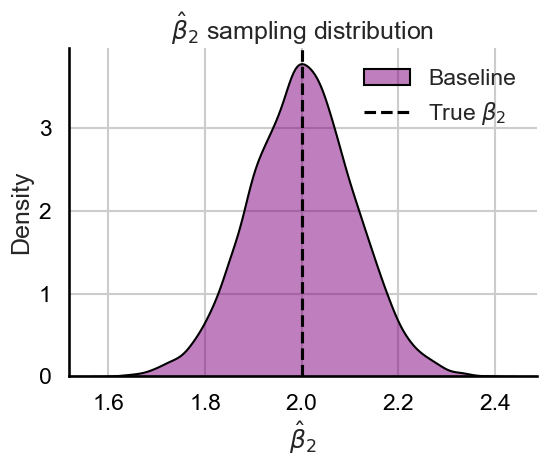

In [20]:
betas_base = simulate_betas(n=1000, sigma_eps=32, sigma_v=16, reps=10000)

fig, ax = plt.subplots(figsize=(6,5))

sns.kdeplot(betas_base, fill=True, alpha=0.5, color="purple", label="Baseline", edgecolor="black", ax=ax)
plt.axvline(2, color="black", ls="--", label=r"True $\beta_2$")

plt.title(r"$\hat{\beta}_2$ sampling distribution")
plt.xlabel(r"$\hat{\beta}_2$")

# Hide top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set bottom and left spines to black
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# Set tick color to black
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.tight_layout()

plt.legend(frameon=False)
plt.show()

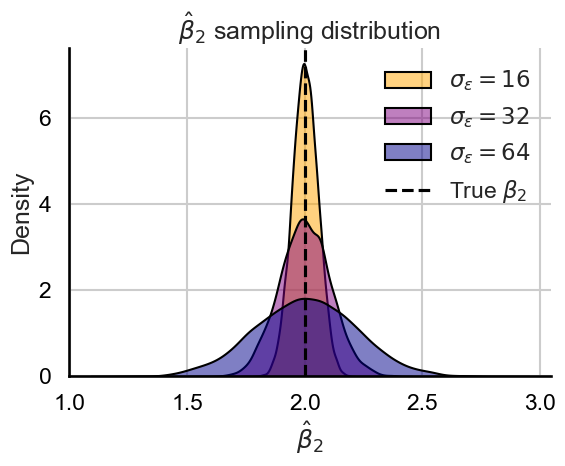

In [21]:
betas_base = simulate_betas(n=1000, sigma_eps=32, sigma_v=16, reps=10000)
betas_low_sigma = simulate_betas(n=1000, sigma_eps=16, sigma_v=16, reps=10000)

betas_high_sigma = simulate_betas(n=1000, sigma_eps=64, sigma_v=16, reps=10000)

fig, ax = plt.subplots(figsize=(6,5))

sns.kdeplot(betas_low_sigma, fill=True, alpha=0.5, color = 'orange', label=r"$\sigma_{\varepsilon}=16$", edgecolor="black", ax=ax)
sns.kdeplot(betas_base, fill=True, alpha=0.5, color= 'purple',label=r"$\sigma_{\varepsilon}=32$", edgecolor="black", ax=ax)
sns.kdeplot(betas_high_sigma, fill=True, alpha=0.5, color = 'darkblue', label=r"$\sigma_{\varepsilon}=64$", edgecolor="black", ax=ax)

plt.axvline(2, color="black", ls="--", label=r"True $\beta_2$")

plt.title(r"$\hat{\beta}_2$ sampling distribution")
plt.xlabel(r"$\hat{\beta}_2$")

# Hide top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set bottom and left spines to black
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# Set tick color to black
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.tight_layout()

plt.legend(frameon=False)
plt.show()

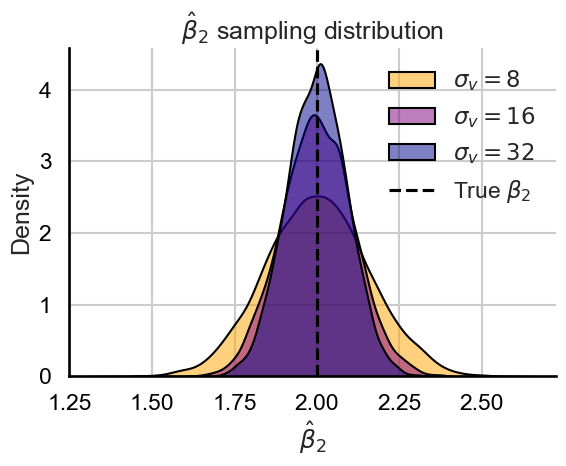

In [22]:

betas_high_collinear = simulate_betas(n=1000, sigma_eps=32, sigma_v=32, reps=10000)
betas_low_collinear = simulate_betas(n=1000, sigma_eps=32, sigma_v=8, reps=10000)

fig, ax = plt.subplots(figsize=(6,5))

sns.kdeplot(betas_low_collinear, fill=True, alpha=0.5, color = 'orange', label=r"$\sigma_{v}=8$", edgecolor="black", ax=ax)
sns.kdeplot(betas_base, fill=True, alpha=0.5, color= 'purple',label=r"$\sigma_{v}=16$", edgecolor="black", ax=ax)
sns.kdeplot(betas_high_collinear, fill=True, alpha=0.5, color = 'darkblue', label=r"$\sigma_{v}=32$", edgecolor="black", ax=ax)

plt.axvline(2, color="black", ls="--", label=r"True $\beta_2$")

plt.title(r"$\hat{\beta}_2$ sampling distribution")
plt.xlabel(r"$\hat{\beta}_2$")

# Hide top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set bottom and left spines to black
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# Set tick color to black
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.tight_layout()

plt.legend(frameon=False)
plt.show()

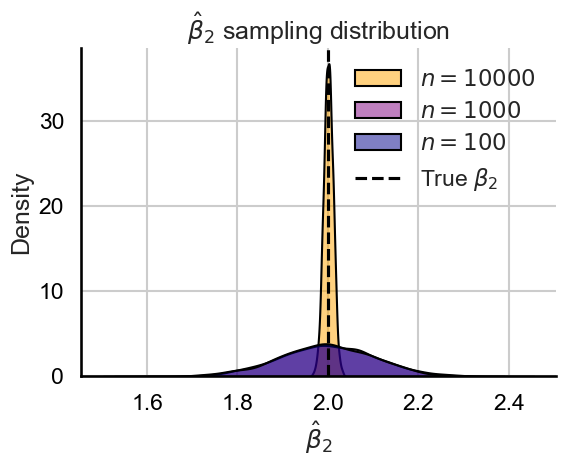

In [23]:

betas_large_sample = simulate_betas(n=10000)
betas_small_sample = simulate_betas(n=100)



fig, ax = plt.subplots(figsize=(6,5))

sns.kdeplot(betas_large_sample, fill=True, alpha=0.5, color = 'orange', label=r"$n=10000$", edgecolor="black", ax=ax)
sns.kdeplot(betas_base, fill=True, alpha=0.5, color= 'purple',label=r"$n=1000$", edgecolor="black", ax=ax)
sns.kdeplot(betas_small_sample, fill=True, alpha=0.5, color= 'darkblue',label=r"$n=100$", edgecolor="black", ax=ax)

plt.axvline(2, color="black", ls="--", label=r"True $\beta_2$")

plt.title(r"$\hat{\beta}_2$ sampling distribution")
plt.xlabel(r"$\hat{\beta}_2$")

# Hide top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set bottom and left spines to black
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# Set tick color to black
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.tight_layout()

plt.legend(frameon=False)
plt.show()

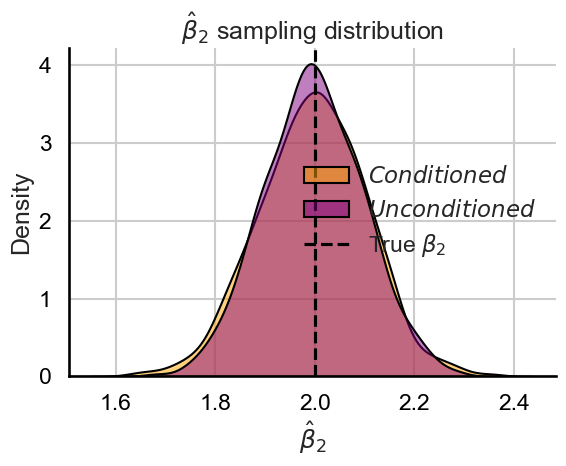

In [24]:
betas_base_cond = simulate_betas()
betas_base_uncond = simulate_betas(conditional=True)



fig, ax = plt.subplots(figsize=(6,5))

sns.kdeplot(betas_base_cond, fill=True, alpha=0.5, color = 'orange', label=r"$Conditioned$", edgecolor="black", ax=ax)
sns.kdeplot(betas_base_uncond, fill=True, alpha=0.5, color= 'purple',label=r"$Unconditioned$", edgecolor="black", ax=ax)

plt.axvline(2, color="black", ls="--", label=r"True $\beta_2$")

plt.title(r"$\hat{\beta}_2$ sampling distribution")
plt.xlabel(r"$\hat{\beta}_2$")

# Hide top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set bottom and left spines to black
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# Set tick color to black
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.tight_layout()

plt.legend(frameon=False)
plt.show()

## Key Takeaways

| Scenario | What Happens to $Var(\hat\beta)$ | Intuition |
|-----------|-----------------------------------|------------|
| Higher error variance | ↑ | More noise → less precise |
| Higher collinearity | ↑↑ | Redundant regressors → unstable estimates |
| Larger sample n | ↓ | Consistency of OLS |
| Conditional vs Unconditional | Similar centers, different spreads | Sources of randomness differ |

Monte Carlo simulation helps visualize the small-sample behavior of estimators and verify theoretical properties.
